In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])  # 불용어처리

In [55]:
import pandas as pd
data = pd.read_csv('/Users/moon-il/Downloads/abcnews-date-text.csv', error_bad_lines=False);

In [56]:
data['publish_date'] = pd.to_datetime(data['publish_date'].astype(str), format = '%Y%m%d')

In [57]:
data['publish_date'] = pd.DatetimeIndex(data['publish_date']).year

In [58]:
data2 = data['headline_text']

data2

0          aba decides against community broadcasting lic...
1             act fire witnesses must be aware of defamation
2             a g calls for infrastructure protection summit
3                   air nz staff in aust strike for pay rise
4              air nz strike to affect australian travellers
5                          ambitious olsson wins triple jump
6                 antic delighted with record breaking barca
7          aussie qualifier stosur wastes four memphis match
8               aust addresses un security council over iraq
9                 australia is locked into war timetable opp
10         australia to contribute 10 million in aid to iraq
11         barca take record as robson celebrates birthda...
12                                bathhouse plans move ahead
13             big hopes for launceston cycling championship
14                    big plan to boost paroo water supplies
15                    blizzard buries united states in bills
16            brigadier 

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['headline_text']))

In [8]:

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_nostops = pd.Series(data_words_nostops)
data_lemmatized = data_words_nostops.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

In [12]:
temp = data
temp['lemmatize'] = data_lemmatized
for i in range(15):
    globals()['trend{}'.format(i+2003)] = temp.loc[temp.publish_date == i+2003]

In [38]:
trend_list = [trend2003, trend2004, trend2005, trend2006, trend2007, trend2008, trend2009, trend2010, trend2011, trend2012, trend2013, trend2014, trend2015, trend2016, trend2017]

,publish_date,headline_text,lemmatize
0,2003,aba decides against community broadcasting lic...,"[aba, decide, community, broadcast, licence]"
1,2003,act fire witnesses must be aware of defamation,"[act, fire, witness, must, aware, defamation]"
2,2003,a g calls for infrastructure protection summit,"[call, infrastructure, protection, summit]"
3,2003,air nz staff in aust strike for pay rise,"[air, nz, staff, aust, strike, pay, rise]"
4,2003,air nz strike to affect australian travellers,"[air, nz, strike, affect, australian, travellers]"
5,2003,ambitious olsson wins triple jump,"[ambitious, olsson, win, triple, jump]"
6,2003,antic delighted with record breaking barca,"[antic, delight, record, break, barca]"
7,2003,aussie qualifier stosur wastes four memphis match,"[aussie, qualifier, stosur, waste, four, memph..."
8,2003,aust addresses un security council over iraq,"[aust, address, un, security, council, iraq]"
9,2003,australia is locked into war timetable opp,"[australia, lock, war, timetable, opp]"


In [14]:
lemmatized = list(trend2015['lemmatize'])
id2word = corpora.Dictionary(lemmatized)
texts = lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -25.653485552404735

Coherence Score:  0.4240479090789065


In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.162*"australian" + 0.146*"call" + 0.109*"melbourne" + 0.077*"price" + '
  '0.051*"western" + 0.046*"high" + 0.044*"victoria" + 0.043*"four" + '
  '0.033*"prepare" + 0.031*"girl"'),
 (1,
  '0.125*"attack" + 0.112*"back" + 0.108*"mine" + 0.062*"deal" + 0.059*"fan" + '
  '0.057*"celebrate" + 0.049*"target" + 0.041*"hill" + 0.037*"party" + '
  '0.033*"reveal"'),
 (2,
  '0.290*"fire" + 0.136*"nsw" + 0.130*"hobart" + 0.114*"rural" + 0.072*"world" '
  '+ 0.036*"boat" + 0.032*"turn" + 0.013*"flight" + 0.011*"around" + '
  '0.006*"well"'),
 (3,
  '0.285*"country" + 0.256*"hour" + 0.100*"podcast" + 0.033*"leaders" + '
  '0.030*"thursday" + 0.019*"abbott" + 0.018*"tony" + 0.014*"policy" + '
  '0.012*"agricultural" + 0.009*"shorten"'),
 (4,
  '0.307*"new" + 0.220*"year" + 0.076*"force" + 0.074*"fall" + 0.063*"dead" + '
  '0.044*"tas" + 0.028*"farmer" + 0.017*"fruit" + 0.008*"philippines" + '
  '0.007*"injury"'),
 (5,
  '0.286*"qld" + 0.182*"release" + 0.002*"paper" + 0.000*"north" + '
  

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.217051 -0.324404       1        1  9.922786
16    -0.172629  0.240925       2        1  8.387595
7     -0.058656  0.012300       3        1  8.163457
0     -0.056433  0.011636       4        1  7.298059
11    -0.055908  0.011460       5        1  7.210085
2     -0.108996  0.037820       6        1  6.593976
1      0.010440 -0.002528       7        1  6.204360
4     -0.149508  0.096344       8        1  5.983820
10    -0.035236  0.005823       9        1  5.929452
17    -0.006704  0.000121      10        1  5.731902
9      0.059963 -0.007886      11        1  4.774662
6      0.066907 -0.008448      12        1  4.409493
12     0.072380 -0.008824      13        1  4.130540
3      0.037891 -0.005818      14        1  3.786621
19     0.050449 -0.007050      15        1  3.650335
13     0.100445 -0.010407      16        1  2.608285
14     0.106943 -0.010615      17        1  2.404378
18     0.118724 -0.010435      18        1  1.331994
5      0.118621 -0.010457      19        1  1.320464
15     0.118358 -0.009557      20        1  0.157738, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
129    Default  10472.000000          police  10472.000000  30.0000  30.0000
258    Default   8828.000000             man   8828.000000  29.0000  29.0000
94     Default   9048.000000            fire   9048.000000  28.0000  28.0000
11     Default   8675.000000             new   8675.000000  27.0000  27.0000
25     Default   8579.000000             say   8579.000000  26.0000  26.0000
58     Default   6640.000000       australia   6640.000000  25.0000  25.0000
9      Default   6226.000000            year   6226.000000  24.0000  24.0000
392    Default   4542.000000              wa   4542.000000  23.0000  23.0000
309    Default   5108.000000         country   5108.000000  22.0000  22.0000
102    Default   6086.000000            find   6086.000000  21.0000  21.0000
197    Default   6186.000000              sa   6186.000000  20.0000  20.0000
310    Default   4589.000000            hour   4589.000000  19.0000  19.0000
190    Default   5587.000000      australian   5587.000000  18.0000  18.0000
141    Default   4603.000000           south   4603.000000  17.0000  17.0000
53     Default   4226.000000             day   4226.000000  16.0000  16.0000
280    Default   5035.000000            call   5035.000000  15.0000  15.0000
373    Default   4183.000000      queensland   4183.000000  14.0000  14.0000
312    Default   4238.000000             nsw   4238.000000  13.0000  13.0000
173    Default   4048.000000          hobart   4048.000000  12.0000  12.0000
358    Default   2881.000000            test   2881.000000  11.0000  11.0000
115    Default   3667.000000          attack   3667.000000  10.0000  10.0000
20     Default   3796.000000             two   3796.000000   9.0000   9.0000
283    Default   3776.000000       melbourne   3776.000000   8.0000   8.0000
222    Default   3559.000000           rural   3559.000000   7.0000   7.0000
57     Default   2876.000000           years   2876.000000   6.0000   6.0000
0      Default   3583.000000        adelaide   3583.000000   5.0000   5.0000
160    Default   4062.000000           court   4062.000000   4.0000   4.0000
34     Default   2926.000000          league   2926.000000   3.0000   3.0000
395    Default   3278.000000            kill   3278.000000   2.0000   2.0000
241    Default   3287.000000            back   3287.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
4642   Topic20      0.023984         propose      3.294710   1.5293 -10.3446
1767   Topic20      0.023984         victims      3.294843   1.5293 -10.3446
550    Topic20      0.023983       education      3.294687   1.5293 -10.3446
1054   Topic20     

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/moon-il/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

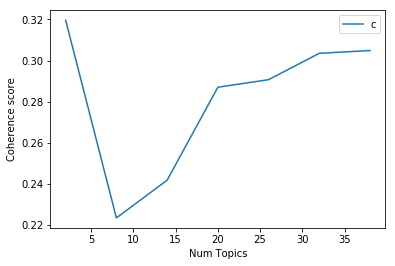

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3196
Num Topics = 8  has Coherence Value of 0.2234
Num Topics = 14  has Coherence Value of 0.2417
Num Topics = 20  has Coherence Value of 0.287
Num Topics = 26  has Coherence Value of 0.2907
Num Topics = 32  has Coherence Value of 0.3035
Num Topics = 38  has Coherence Value of 0.3049


In [30]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.073*"australia" + 0.049*"world" + 0.042*"cup" + 0.028*"test" + '
  '0.024*"beat" + 0.019*"rugby" + 0.016*"day" + 0.014*"final" + 0.013*"play" + '
  '0.013*"cricket"'),
 (1,
  '0.037*"call" + 0.027*"wa" + 0.025*"job" + 0.021*"support" + 0.021*"group" + '
  '0.021*"council" + 0.021*"deal" + 0.018*"push" + 0.017*"mp" + 0.017*"green"'),
 (2,
  '0.031*"court" + 0.019*"give" + 0.019*"case" + 0.018*"force" + 0.018*"png" + '
  '0.017*"island" + 0.016*"appeal" + 0.014*"free" + 0.014*"chief" + '
  '0.013*"anti"'),
 (3,
  '0.051*"fire" + 0.034*"canberra" + 0.032*"house" + 0.032*"home" + '
  '0.027*"tasmania" + 0.022*"hunter" + 0.019*"years" + 0.018*"northern" + '
  '0.017*"train" + 0.014*"build"'),
 (4,
  '0.069*"country" + 0.069*"nsw" + 0.062*"rural" + 0.061*"hour" + 0.047*"sa" + '
  '0.041*"qld" + 0.036*"wa" + 0.032*"nt" + 0.031*"national" + 0.029*"podcast"'),
 (5,
  '0.044*"sydney" + 0.038*"melbourne" + 0.024*"brisbane" + 0.024*"adelaide" + '
  '0.023*"port" + 0.021*"newcastle" + 0.0

In [35]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [48]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data2)



In [49]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.0744,"fire, canberra, house, home, tasmania, hunter,...",aba decides against community broadcasting lic...
1,1,1.0,0.0648,"call, wa, job, support, group, council, deal, ...",act fire witnesses must be aware of defamation
2,2,12.0,0.0660,"government, fund, health, tasmanian, concern, ...",a g calls for infrastructure protection summit
3,3,16.0,0.0813,"kill, crash, hit, die, car, police, drug, shoo...",air nz staff in aust strike for pay rise
4,4,16.0,0.0818,"kill, crash, hit, die, car, police, drug, shoo...",air nz strike to affect australian travellers
5,5,16.0,0.0828,"kill, crash, hit, die, car, police, drug, shoo...",ambitious olsson wins triple jump
6,6,3.0,0.0778,"fire, canberra, house, home, tasmania, hunter,...",antic delighted with record breaking barca
7,7,8.0,0.1163,"live, minister, ban, hospital, afl, nrl, sign,...",aussie qualifier stosur wastes four memphis match
8,8,0.0,0.0636,"australia, world, cup, test, beat, rugby, day,...",aust addresses un security council over iraq
9,9,0.0,0.0804,"australia, world, cup, test, beat, rugby, day,...",australia is locked into war timetable opp


In [59]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1911,"australia, world, cup, test, beat, rugby, day,...",cambodian appeals life sentence for backpacker
1,1.0,0.1667,"call, wa, job, support, group, council, deal, ...",britain expresses reservations over us military
2,2.0,0.1734,"court, give, case, force, png, island, appeal,...",malaysia mulls vertical burial as land shortage
3,3.0,0.1667,"fire, canberra, house, home, tasmania, hunter,...",appeal court begins hanson ettridge hearing
4,4.0,0.1619,"country, nsw, rural, hour, sa, qld, wa, nt, na...",woman sexually assaulted in hobart city area


In [60]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"fire, canberra, house, home, tasmania, hunter,...",5192.0,0.0666
1,1.0,"call, wa, job, support, group, council, deal, ...",4424.0,0.0568
2,12.0,"government, fund, health, tasmanian, concern, ...",4138.0,0.0531
3,16.0,"kill, crash, hit, die, car, police, drug, shoo...",4482.0,0.0575
4,16.0,"kill, crash, hit, die, car, police, drug, shoo...",4768.0,0.0612
5,16.0,"kill, crash, hit, die, car, police, drug, shoo...",4102.0,0.0526
6,3.0,"fire, canberra, house, home, tasmania, hunter,...",3866.0,0.0496
7,8.0,"live, minister, ban, hospital, afl, nrl, sign,...",3752.0,0.0481
8,0.0,"australia, world, cup, test, beat, rugby, day,...",3785.0,0.0486
9,0.0,"australia, world, cup, test, beat, rugby, day,...",3570.0,0.0458
